# Kaleb Kinder

## Predicting Flight Status

### Summary

For this project I will explore publicly available data from The Bureau of Transportation (https://www.transtats.bts.gov) to explore features associated with flight status (on time versus delayed)

#### **Goal**: Predict Flight Status (on time or delayed) based on relevant features

#### Database Schema

Number of attributes: 5 million rows and 36 columns post feature engineering

Outcome variable: 
* Flight Status - On time or delayed (binary outcome)

Feature Information: 

* Flight Date - day,month,year of flight
* Airline - airline names
* Cancelled - flight cancellelation status
* DepDelay - Departure Delay in minutes. Negative values = early departures

I will be using flight data from 2020 classifying flight status based on the above features. These features were chosen based on airline domain knowledge (e.g., busier months predicting delayed flights).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

# 1. Data Acquisition

In [2]:
#Define relevant features to explore
column_subset = [
    'FlightDate',
    'Airline',
    'Cancelled',
    'DepDelay',
]

In [3]:
year = 2020 #data for 2020

df=pd.read_csv('Combined_Flights_' + str(year) +'.csv',usecols=column_subset)


**1.1 Check the data with head(), info(), and describe()**

In [4]:
df.head()

,FlightDate,Airline,Cancelled,DepDelay
0,2020-09-01,Comair Inc.,False,-7.0
1,2020-09-02,Comair Inc.,False,-7.0
2,2020-09-03,Comair Inc.,False,-10.0
3,2020-09-04,Comair Inc.,False,-8.0
4,2020-09-05,Comair Inc.,False,-9.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5022397 entries, 0 to 5022396
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   FlightDate  object 
 1   Airline     object 
 2   Cancelled   bool   
 3   DepDelay    float64
dtypes: bool(1), float64(1), object(2)
memory usage: 119.7+ MB


In [6]:
df.describe()

#Mean flight departure delay is ~2 minutes

,DepDelay
count,4.722714e+06
mean,2.064780e+00
std,3.639112e+01
min,-1.310000e+02
25%,-7.000000e+00
50%,-4.000000e+00
75%,-1.000000e+00
max,3.890000e+03


# 2. Data Cleaning

**2.1 Missing Data**

In [7]:
# Check for the percentage of missing values across features

df.isnull().sum()* 100 / len(df)

# 5.9% of departure delay data is missing

FlightDate    0.000000
Airline       0.000000
Cancelled     0.000000
DepDelay      5.966932
dtype: float64

In [8]:
# Cancelled Flights would not have a delay value 
# Check if this explains missing values

df[df['DepDelay'].isnull() & (df['Cancelled'] == True)].isnull().sum()*100/len(df)

#Confirmed that cancelled flights explain all instances of missing values
# (All null values for Departure Delay occur when there is a cancellation)

FlightDate    0.000000
Airline       0.000000
Cancelled     0.000000
DepDelay      5.966932
dtype: float64

In [9]:
# Remove the missing delay values due to cancellations

df.dropna(inplace=True)

# 3. EDA & Feature Engineering

**3.1 Check Distribution of Flight Delay Minutes (target)**

Text(0.5, 0, 'Delay Minutes')

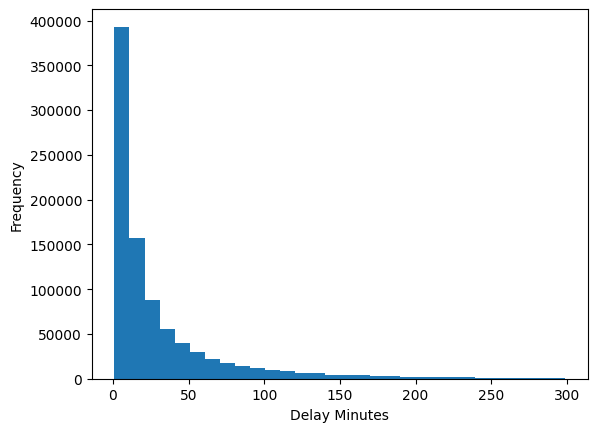

In [10]:
df.query('(DepDelay > 0) and (DepDelay < 300)')['DepDelay'].plot(kind='hist',bins=30)
plt.xlabel("Delay Minutes")

# Most of the delays are short (< 15 minutes)

# To avoid extreme class imbalance (short vs long delays), flight status will simply
# be engineered as a binary outcome (on time or delayed) 

**3.2 Explore and Filter Airlines**

In [11]:
# Explore airlines with the top 10 most flights
df['Airline'].value_counts().nlargest(10)

Airline
Southwest Airlines Co.    883585
SkyWest Airlines Inc.     572309
Delta Air Lines Inc.      552392
American Airlines Inc.    535656
United Air Lines Inc.     285686
Republic Airlines         209310
Endeavor Air Inc.         204543
Envoy Air                 200343
Comair Inc.               178602
JetBlue Airways           136214
Name: count, dtype: int64

In [12]:
#Filter Airlines that are not in the Top 10

df = df[df['Airline'].map(df['Airline'].value_counts()) >= 144163]

df.reset_index(inplace=True)
df.drop(['index'],axis=1,inplace=True)
df.head()

,FlightDate,Airline,Cancelled,DepDelay
0,2020-09-01,Comair Inc.,False,-7.0
1,2020-09-02,Comair Inc.,False,-7.0
2,2020-09-03,Comair Inc.,False,-10.0
3,2020-09-04,Comair Inc.,False,-8.0
4,2020-09-05,Comair Inc.,False,-9.0


**3.3 Create Binary Outcome Variable for Flight Status**

In [13]:
#Flight Time (outcome variable)


df['Flight Status'] = None

df.loc[df['DepDelay'] <= 0, 'Flight Status'] = 'On Time'
df.loc[df['DepDelay'] > 0, 'Flight Status'] = 'Delayed'

# Another option would have been to categorize Flight Status multinomially, looking at small, medium, and larger delays. 
# However, I decided group all delays due to the skewed distribution of delay minutes (see graph above)


<Axes: xlabel='Flight Status', ylabel='count'>

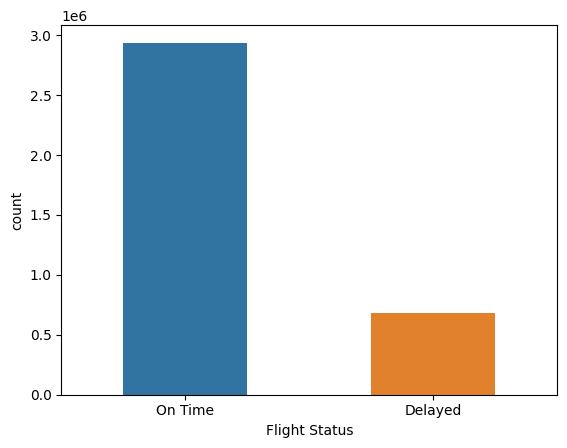

In [14]:
sns.countplot(x='Flight Status',data=df,order = df['Flight Status'].value_counts().index,width=0.5)

#Class is moderately imbalanced, as expected

**3.4 Explore Flight Status across Airlines**

Text(0.5, 1.0, 'Flight Status Count by Airline')

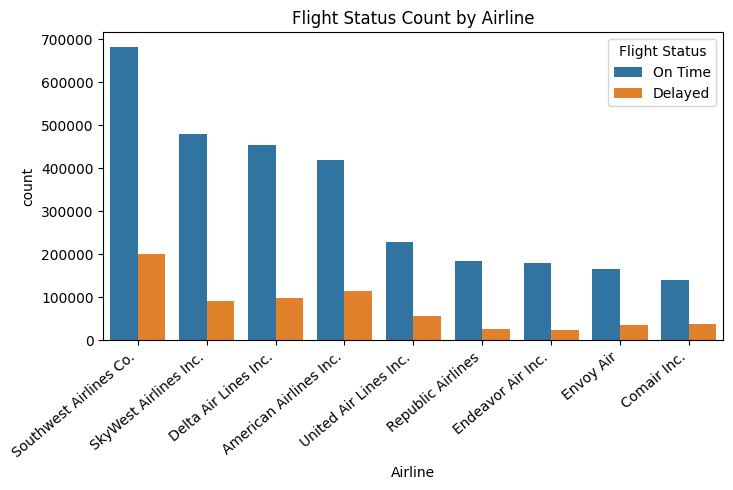

In [15]:
plt.figure(figsize=(8,4))
ax = sns.countplot(x='Airline',data=df,hue='Flight Status',order=df['Airline'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout

plt.title('Flight Status Count by Airline')


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

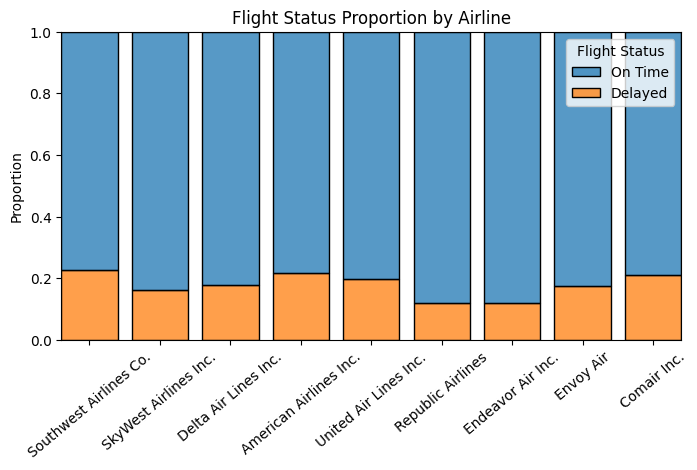

In [16]:
plt.figure(figsize=(8,4))

airline_proportion = pd.Categorical(df['Airline'],categories=['Southwest Airlines Co.','SkyWest Airlines Inc.','Delta Air Lines Inc.','American Airlines Inc.','United Air Lines Inc.','Republic Airlines','Endeavor Air Inc.','Envoy Air','Comair Inc.'],ordered=True)

ax = sns.histplot(data = df,x = airline_proportion, hue=df['Flight Status'],multiple="fill",stat = 'proportion', shrink = 0.8,common_norm=True) 
ax.set_xticks(df['Airline'].unique())
ax.set_xticklabels(ax.get_xticklabels(),rotation=40)
plt.title('Flight Status Proportion by Airline')

plt.tight_layout

# At a glance, the Airline feature does not appear to be a good predictor of Flight Status (little variance between airlines)

**3.5 Engineer Months and Day of Week Features**

In [17]:
#Create Month and Day of the Week features
FlightDate = pd.to_datetime(df['FlightDate']) #convert FlightDate to datetime format

df['Month'] = FlightDate.dt.month_name() #make month feature
df['Day of Week'] = FlightDate.dt.day_name() #make day of week feature

df.head()

,FlightDate,Airline,Cancelled,DepDelay,Flight Status,Month,Day of Week
0,2020-09-01,Comair Inc.,False,-7.0,On Time,September,Tuesday
1,2020-09-02,Comair Inc.,False,-7.0,On Time,September,Wednesday
2,2020-09-03,Comair Inc.,False,-10.0,On Time,September,Thursday
3,2020-09-04,Comair Inc.,False,-8.0,On Time,September,Friday
4,2020-09-05,Comair Inc.,False,-9.0,On Time,September,Saturday


**3.6 Explore Flight Status across Months**

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

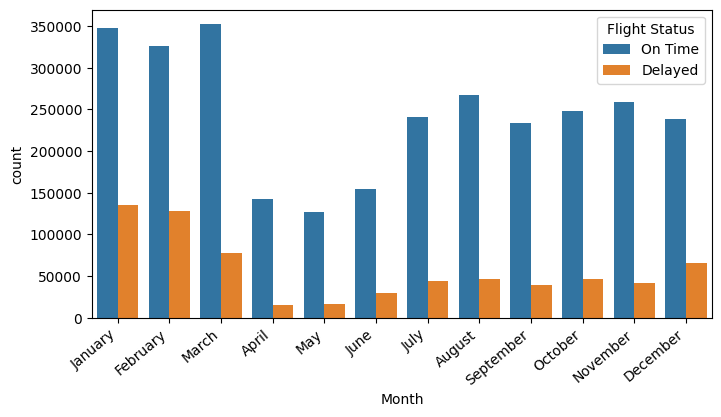

In [18]:
Month = ['January','February','March','April','May','June','July','August','September','October','November','December']
plt.figure(figsize=(8,4))
ax = sns.countplot(x='Month',data=df,hue='Flight Status',order = Month)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout

#Jan-March had the most flights. April-June had the least flights

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

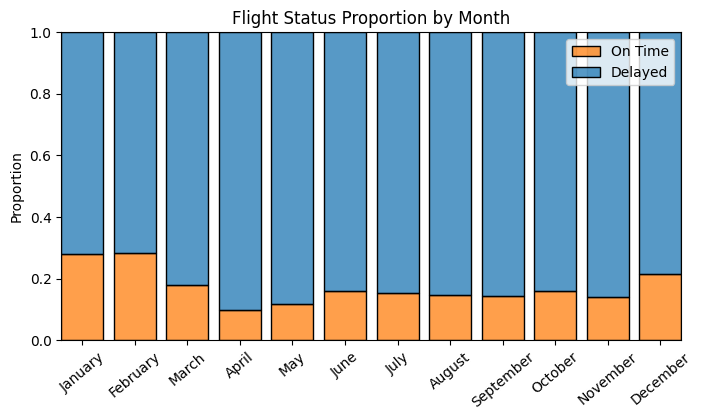

In [19]:
plt.figure(figsize=(8,4))

month_proportion = pd.Categorical(df['Month'],categories=['January','February','March','April','May','June','July','August','September','October','November','December'],ordered=True)

ax = sns.histplot(data= df,x = month_proportion, hue=df['Flight Status'],multiple="fill",stat = 'proportion', shrink = 0.8,common_norm=True) 
ax.set_xticks(Month)
ax.set_xticklabels(Month,rotation=40)

plt.title('Flight Status Proportion by Month')
plt.legend(df['Flight Status'].unique(),loc='upper right')
plt.tight_layout

# Observation: The Winter Months have the highest proportion of delays

**3.7 Explore Flight Status across Day of the Week**

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

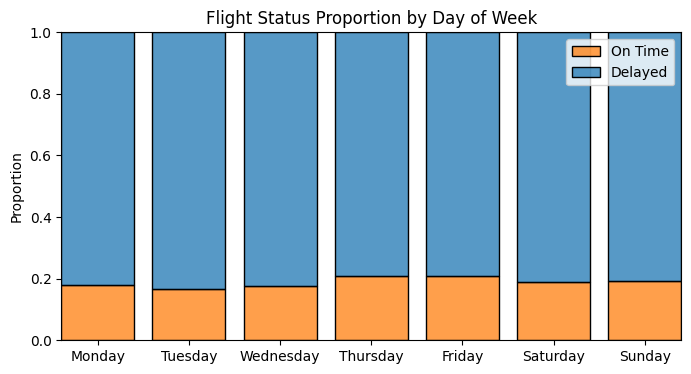

In [20]:
plt.figure(figsize=(8,4))

day_proportion = pd.Categorical(df['Day of Week'],categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],ordered=True)

ax = sns.histplot(data= df,x = day_proportion, hue=df['Flight Status'],multiple="fill",stat = 'proportion', shrink = 0.8,common_norm=True) 

plt.title('Flight Status Proportion by Day of Week')
plt.legend(df['Flight Status'].unique(),loc='upper right')
plt.tight_layout

# Flight Status appears similar across day of the week

# 4.Data Preprocessing

**4.1 Convert categorical features to dummy codes**

In [21]:
#Create dummy variables: Convert string to numerical dummy codes for ML model to interpret

category_features=['Airline','Month','Day of Week'] #'Flight Status'

In [22]:
#Create new dataframe that includes the new dummy coded features

model_data = pd.get_dummies(df,columns=category_features,dtype='float')
category_features=['Flight Status']
model_data = pd.get_dummies(model_data,columns=category_features,dtype='float',drop_first=True)
model_data.head()


,FlightDate,Cancelled,DepDelay,Airline_American Airlines Inc.,Airline_Comair Inc.,Airline_Delta Air Lines Inc.,Airline_Endeavor Air Inc.,Airline_Envoy Air,Airline_Republic Airlines,Airline_SkyWest Airlines Inc.,...,Month_October,Month_September,Day of Week_Friday,Day of Week_Monday,Day of Week_Saturday,Day of Week_Sunday,Day of Week_Thursday,Day of Week_Tuesday,Day of Week_Wednesday,Flight Status_On Time
0,2020-09-01,False,-7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,2020-09-02,False,-7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,2020-09-03,False,-10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,2020-09-04,False,-8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2020-09-05,False,-9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [23]:
model_data.columns.values

array(['FlightDate', 'Cancelled', 'DepDelay',
       'Airline_American Airlines Inc.', 'Airline_Comair Inc.',
       'Airline_Delta Air Lines Inc.', 'Airline_Endeavor Air Inc.',
       'Airline_Envoy Air', 'Airline_Republic Airlines',
       'Airline_SkyWest Airlines Inc.', 'Airline_Southwest Airlines Co.',
       'Airline_United Air Lines Inc.', 'Month_April', 'Month_August',
       'Month_December', 'Month_February', 'Month_January', 'Month_July',
       'Month_June', 'Month_March', 'Month_May', 'Month_November',
       'Month_October', 'Month_September', 'Day of Week_Friday',
       'Day of Week_Monday', 'Day of Week_Saturday', 'Day of Week_Sunday',
       'Day of Week_Thursday', 'Day of Week_Tuesday',
       'Day of Week_Wednesday', 'Flight Status_On Time'], dtype=object)

# 5. Train the Random Forest Model to predict Flight Status

**5.1 Use sklearn to split the data into a training dataset and a test dataset**

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
X=model_data.drop(['Cancelled','DepDelay','FlightDate','Flight Status_On Time'],axis=1) #drop outcome variable and non features
y=model_data['Flight Status_On Time'] #define binary outcome variable as Flight Status (on time or delayed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30) #30% of data randomly assigned to test dataset

**5.2 Fit the model to the training dataset**

In [26]:
from sklearn.ensemble import RandomForestClassifier #import the random forest model

In [27]:
#Fit model
rfc = RandomForestClassifier(n_estimators=300)
rfc.fit(X_train,y_train) 

RandomForestClassifier(n_estimators=300)

# 6. Evaluating Model Predictions

In [28]:
predictions = rfc.predict(X_test)

In [29]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [30]:
acc = accuracy_score(y_test, predictions)
print("Flight Status Prediction Accuracy: "+"{:.0%}".format(acc));

Flight Status Prediction Accuracy: 81%


In [31]:
"""
Overall, the model had high accuracy (81%) predicting Flight Status. 

However, the classification report showed that while the model performed well
at predicting On Time flight status, it did not perform well at predicting Delayed 
flight status. In the next step I evaluate the contribution of each feature on the 
prediction of the model to better understand how the model predicted flight status 
(delayed flights in particular)
"""
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.55      0.00      0.01    206294
         1.0       0.81      1.00      0.90    880434

    accuracy                           0.81   1086728
   macro avg       0.68      0.50      0.45   1086728
weighted avg       0.76      0.81      0.73   1086728



# 7. Examine Feature Importance

Text(0.5, 1.0, 'Which Feature was most Important predicting Flight Status?')

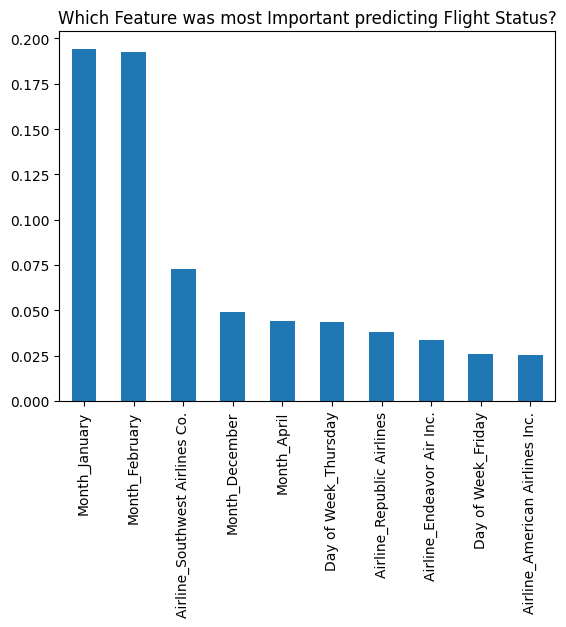

In [32]:
feature_importances = pd.Series(rfc.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_importances.nlargest(10).plot.bar()
plt.title('Which Feature was most Important predicting Flight Status?')

# 8. Conclusions

* The random forest classification model predicted flight status overall at 90% accuracy

* The Features January and February were the most important for predicting whether a flight was delayed or on time (likely due to winter weather). Airlines could use these data to adjust resources allocated during these months or adjust flight schedules to reduce delays.
